This notebook reproduces Figures 4 and S6.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Arial'

In [2]:
# load data
synapse_occupation_downstream_top=pd.read_csv('../data/Fig4_S6/A02l_A1_downstream_top_synapse_occupation_percentage.csv')
synapse_occupation_upstream_top=pd.read_csv('../data/Fig4_S6/A02l_A1_upstream_top_synapse_occupation_percentage.csv')

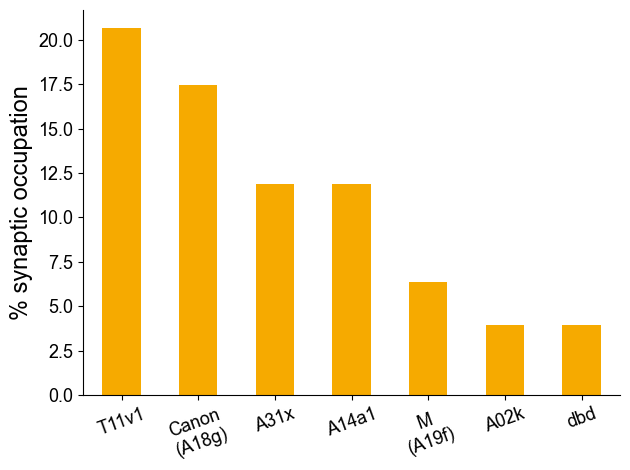

In [3]:
#Fig4B
synapse_occupation_upstream_top.plot(x='Unnamed: 0', y='Synapse occupation (%)', kind='bar',color=(246/255,170/255,0/255))
plt.xticks(rotation=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend().set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% synaptic occupation', fontsize=17)
plt.xlabel('')
plt.tight_layout()
plt.savefig('figures/Fig4B.svg')

<Figure size 500x400 with 0 Axes>

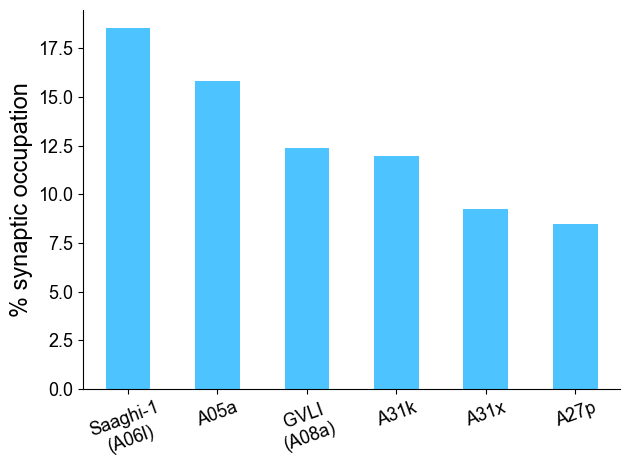

In [4]:
#Fig4D
plt.figure(figsize =(5, 4))
synapse_occupation_downstream_top.plot(x='Unnamed: 0', y='Synapse occupation (%)', kind='bar',color=(77/255,196/255,255/255))
plt.xticks(rotation=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend().set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% synaptic occupation', fontsize=17)
plt.xlabel('')
plt.tight_layout()
plt.savefig('figures/Fig4D.svg')

In [5]:
#Loading adjacency matrix data and comuting and
#computing the synapse occupation rate of the postsynaptic neuron. 
df=pd.read_csv('../data/Fig4_S6/adjacency_matrix.csv', index_col=0) #adjacency matrix of neuronal classes
input=pd.read_csv('../data/Fig4_S6/total_inputs.csv', index_col=0) #total input synapses onto each neuronal class
for key in df.keys():
    if 'Neurons' not in key:
        df[key]=df[key].div(input[key].values[0]/100)

The following code lauches a html file where you can explore the network stucture in Fig S6F.
Loading.json contains the information for reproduce Fig S6F.

In [6]:
# -*- coding: utf-8 -*-
"""
Interactive directed, weighted network viewer (PyVis + vis-network)
- Initial layout: Kamada–Kawai (fixed positions, nodes draggable)
- Edge styling: separate mutual edges via roundness and endpoint offsets
- Edge labels show weights as percentages (%), always visible
- Threshold filter: hide edges below a numeric threshold (0–100, decimals allowed)
- Node editor: rename, change color, change font size (px)
- Edge editor: type, roundness, endpoint offsets, apply to reverse, color, label font size
- PNG export: save the current canvas
- Full state save/load (JSON): positions, node styles, edge styles, threshold, global edge style
- Local HTTP server:
    * serves the current folder (HTML + lib assets)
    * handles POST /save_layout to save JSON into the same folder
    * auto-selects a free port and injects it into HTML
- Opens http://127.0.0.1:<port>/interactive_network.html (same-origin fix)

Input:  preprocessed_adjacency_matrix.csv  (first row/col are node names; values are directed connection strengths in %)
Output: http://127.0.0.1:<port>/interactive_network.html
"""

import os
import json
import threading
from http.server import SimpleHTTPRequestHandler, HTTPServer
import webbrowser
import pandas as pd
import networkx as nx
from pyvis.network import Network

# ===== Local app server: serves files & handles POST /save_layout =====
class AppHandler(SimpleHTTPRequestHandler):
    # Serve the current working directory to expose HTML and PyVis's lib assets.
    def __init__(self, *args, directory=None, **kwargs):
        super().__init__(*args, directory=os.getcwd(), **kwargs)

    def _send_cors(self):
        self.send_header('Access-Control-Allow-Origin', '*')
        self.send_header('Access-Control-Allow-Methods', 'GET, POST, OPTIONS')
        self.send_header('Access-Control-Allow-Headers', 'Content-Type')

    def do_OPTIONS(self):
        self.send_response(200)
        self._send_cors()
        self.end_headers()

    def do_POST(self):
        if self.path != '/save_layout':
            self.send_response(404)
            self._send_cors()
            self.end_headers()
            return
        try:
            length = int(self.headers.get('Content-Length', '0'))
            raw = self.rfile.read(length)
            msg = json.loads(raw.decode('utf-8'))

            fname = msg.get('filename', 'layout.json')
            if not fname.endswith('.json'):
                fname = fname + '.json'

            save_path = os.path.join(os.getcwd(), fname)
            data = msg.get('data', {})

            with open(save_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)

            resp = {'ok': True, 'path': save_path}
            self.send_response(200)
            self._send_cors()
            self.send_header('Content-Type', 'application/json')
            self.end_headers()
            self.wfile.write(json.dumps(resp).encode('utf-8'))
        except Exception as e:
            resp = {'ok': False, 'error': str(e)}
            self.send_response(500)
            self._send_cors()
            self.send_header('Content-Type', 'application/json')
            self.end_headers()
            self.wfile.write(json.dumps(resp).encode('utf-8'))

class ReusableHTTPServer(HTTPServer):
    # Mitigate TIME_WAIT issues
    allow_reuse_address = True

def start_app_server(preferred_ports=None):
    """
    Start the app server (serving current folder + POST /save_layout).
    Returns (server_instance, actual_port).
    Preferred ports: [8765] + [8766..8780] + [0] (OS auto-assign).
    """
    if preferred_ports is None:
        preferred_ports = [8765] + list(range(8766, 8781)) + [0]
    for port in preferred_ports:
        try:
            server = ReusableHTTPServer(('127.0.0.1', port), lambda *a, **k: AppHandler(*a, directory=os.getcwd(), **k))
            th = threading.Thread(target=server.serve_forever, daemon=True)
            th.start()
            actual_port = server.server_address[1]
            print(f"[INFO] App server ready at http://127.0.0.1:{actual_port}/")
            return server, actual_port
        except OSError:
            continue
    print("[WARN] App server could not start (all candidate ports busy).")
    return None, None

# ===== 1) Read CSV (weights are 0–100 %) =====
df.index = df.index.str.strip()
df.columns = df.columns.str.strip()

# ===== 2) Directed, weighted graph =====
G = nx.DiGraph()
for node in df.index:
    G.add_node(node)
for i, src in enumerate(df.index):
    for j, dst in enumerate(df.columns):
        w = float(df.iat[i, j])  # 0–100 numeric
        if w != 0:
            G.add_edge(src, dst, weight=w)

# ===== 3) Initial layout: Kamada–Kawai (use saved layout if available) =====
kk_pos = nx.kamada_kawai_layout(G)  # normalized coordinates (0..1)
def to_pixels(p, scale=700):
    return p * scale

# Load saved state (optional)
layout_path = 'layout.json'
saved_nodes, saved_edges = {}, {}
saved_threshold = None
saved_global_edge = None

if os.path.exists(layout_path):
    try:
        with open(layout_path, 'r', encoding='utf-8') as f:
            payload = json.load(f)
        if isinstance(payload, dict):
            if 'threshold' in payload:
                try:
                    saved_threshold = float(payload['threshold'])
                    saved_threshold = max(0.0, min(100.0, saved_threshold))
                except Exception:
                    saved_threshold = None
            if 'globalEdge' in payload and isinstance(payload['globalEdge'], dict):
                saved_global_edge = payload['globalEdge']

            for n in payload.get('nodes', []):
                nid = str(n.get('id'))
                if nid:
                    saved_nodes[nid] = n
            for e in payload.get('edges', []):
                eid = str(e.get('id')) if e.get('id') is not None else f"{e.get('from')}__{e.get('to')}"
                if eid:
                    saved_edges[eid] = e
            print(f"[INFO] Loaded layout from layout.json (nodes: {len(saved_nodes)}, edges: {len(saved_edges)})")
            if saved_threshold is not None:
                print(f"[INFO] Saved threshold: {saved_threshold}")
            if saved_global_edge:
                print(f"[INFO] Saved globalEdge: {saved_global_edge}")
    except Exception as e:
        print(f"[WARN] Failed to load layout.json: {e}")

# ===== 4) PyVis network (physics OFF + smooth edges) =====
net = Network(height='800px', width='100%', notebook=False, directed=True)
options_dict = {
    "nodes": {"font": {"size": 16}},
    "edges": {
        "color": {"color": "#B279A2"},
        "smooth": {"enabled": True, "type": "continuous"},
        "font": {"size": 13, "align": "middle", "vadjust": 0}
    },
    "interaction": {
        "dragNodes": True, "dragView": True, "zoomView": True, "hover": True
    },
    "physics": {"enabled": False}
}
net.set_options(json.dumps(options_dict))

# ===== 5) Add nodes (fixed but draggable) =====
default_node_color = {"background": "#4C78A8", "border": "#333333"}
for n in G.nodes():
    sn = saved_nodes.get(n)
    if sn:
        x = float(sn.get('x', to_pixels(kk_pos[n][0])))
        y = float(sn.get('y', to_pixels(kk_pos[n][1])))
        label = sn.get('label', n)
        color = sn.get('color', default_node_color)
        font  = sn.get('font', {})
    else:
        x, y = kk_pos[n]
        x, y = to_pixels(x), to_pixels(y)
        label = n
        color = default_node_color
        font  = {}
    net.add_node(
        n, label=label,
        x=x, y=y,
        physics=False, fixed=False,
        color=color,
        font=font
    )

# ===== 6) Add edges: mutual separation + weight labels (%) =====
ENDPOINT_OFFSET = 16
pair_counter = {}
BASE_ROUND_MUTUAL = 0.45
STEP_ROUND_MUTUAL = 0.05
BASE_ROUND_SINGLE = 0.30

def edge_id(u, v):
    return f"{u}__{v}"

global_edge_color = None
global_edge_label_size = None
if saved_global_edge:
    if isinstance(saved_global_edge.get('color'), str):
        global_edge_color = saved_global_edge['color']
    if saved_global_edge.get('labelFontSize') is not None:
        try:
            global_edge_label_size = int(saved_global_edge.get('labelFontSize'))
        except Exception:
            global_edge_label_size = None

for u, v, data in G.edges(data=True):
    w = float(data['weight'])        # 0–100
    default_width = 1 + 6 * (w / 100.0)
    default_label = f"{int(round(w))}%"
    eid = edge_id(u, v)

    pair_key = tuple(sorted([u, v]))
    c = pair_counter.get(pair_key, 0)
    pair_counter[pair_key] = c + 1

    if u == v:
        smooth_cfg = {"type": "discrete"}  # self loop
        from_off, to_off = 0, 0
    elif G.has_edge(v, u):
        roundness = min(0.5, BASE_ROUND_MUTUAL + STEP_ROUND_MUTUAL * (c % 3))
        smooth_cfg = {"type": "continuous", "roundness": roundness}
        if u < v:
            from_off, to_off = +ENDPOINT_OFFSET, -ENDPOINT_OFFSET
        else:
            from_off, to_off = -ENDPOINT_OFFSET, +ENDPOINT_OFFSET
    else:
        smooth_cfg = {"type": "continuous", "roundness": BASE_ROUND_SINGLE}
        from_off, to_off = 0, 0

    se = saved_edges.get(eid, {})
    edge_kwargs = {
        "id": eid,
        "value": w,
        "title": f"{u} → {v}: {int(round(w))}%",
        "label": default_label,
        "width": default_width,
        "arrows": "to",
        "smooth": smooth_cfg,
    }

    # Color: per-edge saved > global saved > default
    if se.get('color') is not None:
        edge_kwargs["color"] = se['color']
    elif global_edge_color:
        edge_kwargs["color"] = {"color": global_edge_color}
    else:
        edge_kwargs["color"] = {"color": "#B279A2"}

    # Font: per-edge saved > global saved > default
    if se.get('font') is not None:
        edge_kwargs["font"] = se['font']
    elif global_edge_label_size is not None:
        edge_kwargs["font"] = {"size": global_edge_label_size, "align": "middle", "vadjust": 0}

    if se.get('smooth') is not None:
        edge_kwargs["smooth"] = se['smooth']
    if se.get('endPointOffset') is not None:
        edge_kwargs["endPointOffset"] = se['endPointOffset']
    else:
        if u != v and G.has_edge(v, u):
            edge_kwargs["endPointOffset"] = {"from": from_off, "to": to_off}
    if se.get('width') is not None:
        edge_kwargs["width"] = se['width']

    if saved_threshold is not None and w < saved_threshold:
        edge_kwargs["hidden"] = True

    net.add_edge(u, v, **edge_kwargs)

# ===== 7) Write HTML (PyVis writes HTML + lib folder) =====
out_html = os.path.abspath("interactive_network.html")
net.write_html(out_html, local=True, notebook=False, open_browser=False)
print(f"[INFO] HTML saved to: {out_html}")

# ===== 8) Start app server FIRST (so we know the port), then inject settings =====
app_server, app_port = start_app_server()  # serves the folder and POST /save_layout

with open(out_html, "r", encoding="utf-8") as f:
    html = f.read()

init_js = ""
init_js += "window.initialThreshold = " + (str(saved_threshold) if saved_threshold is not None else "null") + ";\n"
if saved_global_edge:
    init_js += "window.initialGlobalEdge = " + json.dumps(saved_global_edge) + ";\n"
else:
    init_js += "window.initialGlobalEdge = null;\n"
# We know the port now. The UI will prefer location.origin (same server), but we also expose the port explicitly.
init_js += "window.saveServerPort = " + (str(app_port) if app_port is not None else "null") + ";\n"

html = html.replace(
    "var network = new vis.Network(container, data, options);",
    "var network = new vis.Network(container, data, options);\n"
    + init_js +
    "window.network = network;\n"
    "window.nodes = data.nodes;\n"
    "window.edges = data.edges;\n"
)

# ===== 9) Insert English control panel =====
controls_template = r"""
<div id="controls" style="margin:10px 0 16px; font-family: sans-serif;">
  <fieldset style="padding:8px; border:1px solid #ccc; margin-bottom:10px;">
    <legend style="font-weight:bold;">Image Export</legend>
    <div style="display:flex; flex-wrap:wrap; gap:12px; align-items:center;">
      <label>File name:
        <input type="text" id="pngFilename" value="network" style="width:180px; margin-left:4px;">
      </label>
      <button id="savePNG" style="padding:6px 10px;">Save as PNG</button>
    </div>
    <small style="color:#666;">
      The PNG saves the current canvas view. Content outside the viewport won't be included—adjust zoom/pan as needed before saving.
    </small>
  </fieldset>

  <fieldset style="padding:8px; border:1px solid #ccc; margin-bottom:10px;">
    <legend style="font-weight:bold;">Save/Load Layout (full state)</legend>
    <div style="display:flex; flex-wrap:wrap; gap:12px; align-items:center;">
      <label>Save file name:
        <input type="text" id="layoutFilename" value="layout" style="width:160px; margin-left:6px;">
      </label>
      <button id="saveLayout" style="padding:6px 10px;">Save (download)</button>
      <button id="saveLayoutToLocal" style="padding:6px 10px;">Save to same folder (via Python)</button>

      <label>Load (JSON):
        <input type="file" id="loadLayoutFile" accept=".json" style="margin-left:6px;">
      </label>
      <button id="applyLayoutFromFile" style="padding:6px 10px;">Apply selected file</button>
    </div>
    <small style="color:#666;">
      If <code>layout.json</code> exists in the same folder at startup, it will be auto-applied by Python.
    </small>
  </fieldset>

  <fieldset style="padding:8px; border:1px solid #ccc; margin-bottom:10px;">
    <legend style="font-weight:bold;">Threshold (%): hide edges below this weight</legend>
    <div style="display:flex; flex-wrap:wrap; gap:12px; align-items:center;">
      <label>Threshold [%]:
        <input type="number" id="thInput" min="0" max="100" step="0.1" value="0" style="width:120px; margin-left:6px;">
      </label>
      <button id="thApply" style="padding:6px 10px;">Apply</button>
      <button id="thReset" style="padding:6px 10px;">Reset</button>
      <small style="color:#666;">Decimals are supported (e.g., 12.5). Edges with value below this threshold will be hidden.</small>
    </div>
  </fieldset>

  <fieldset style="padding:8px; border:1px solid #ccc; margin-bottom:10px;">
    <legend style="font-weight:bold;">Edge Display (apply to all edges)</legend>
    <div style="display:flex; flex-wrap:wrap; gap:12px; align-items:center;">
      <label>Color (all edges):
        <input type="color" id="edgeGlobalColor" value="#B279A2" style="margin-left:4px;">
      </label>
      <label>Weight label font size (all edges) [px]:
        <input type="number" id="edgeGlobalLabelSize" min="8" max="72" step="1" value="13" style="width:90px; margin-left:4px;">
      </label>
      <button id="applyEdgeGlobalColor" style="padding:6px 10px;">Apply color to all</button>
      <button id="applyEdgeGlobalFont"  style="padding:6px 10px;">Apply font size to all</button>
    </div>
    <small style="color:#666;">These settings are saved under <code>globalEdge</code> in the layout JSON and auto-applied on startup/load.</small>
  </fieldset>

  <fieldset style="padding:8px; border:1px solid #ccc; margin-bottom:10px;">
    <legend style="font-weight:bold;">Node Editor (applies to the selected node)</legend>
    <div style="display:flex; flex-wrap:wrap; gap:12px; align-items:center;">
      <div>Selected node ID: <code id="nodeId">None</code></div>
      <label>Current label: <code id="nodeLabel">-</code></label>
      <label>New label:
        <input type="text" id="nodeLabelInput" placeholder="Enter new label" style="width:240px; margin-left:4px;">
      </label>
      <label>Background color:
        <input type="color" id="nodeColorBg" value="#4C78A8" style="margin-left:4px;">
      </label>
      <label>Border color:
        <input type="color" id="nodeColorBorder" value="#333333" style="margin-left:4px;">
      </label>
      <label>Font size (px):
        <input type="number" id="nodeFontSize" min="6" max="72" step="1" value="16" style="width:90px; margin-left:4px;">
      </label>
      <label>
        <input type="checkbox" id="applyHighlightHover" checked>
        Apply same colors to highlight/hover
      </label>
      <label>
        <input type="checkbox" id="updateEdgeTitles" checked>
        Update related edges' tooltips (title)
      </label>
      <button id="applyNodeLabel" style="padding:6px 10px;">Apply label</button>
      <button id="applyNodeColor" style="padding:6px 10px;">Apply colors</button>
      <button id="applyNodeFont"  style="padding:6px 10px;">Apply font size</button>
    </div>
  </fieldset>

  <fieldset style="padding:8px; border:1px solid #ccc;">
    <legend style="font-weight:bold;">Edge Editor (applies to the selected edge)</legend>
    <div style="display:flex; flex-wrap:wrap; gap:12px; align-items:center;">
      <div>Selected edge ID: <code id="edgeId">None</code></div>
      <div>from: <code id="edgeFrom">-</code>, to: <code id="edgeTo">-</code></div>

      <label>Type:
        <select id="edgeType" style="margin-left:4px;">
          <option value="continuous" selected>continuous (recommended)</option>
          <option value="curvedCW">curvedCW (clockwise)</option>
          <option value="curvedCCW">curvedCCW (counter-clockwise)</option>
          <option value="dynamic">dynamic (for physics)</option>
          <option value="discrete">discrete (self loop)</option>
        </select>
      </label>

      <label>roundness:
        <input type="range" id="edgeRound" min="0" max="1" step="0.01" value="0.45" style="width:180px;">
        <span id="edgeRoundVal">0.45</span>
      </label>

      <label>Endpoint offset (separation):
        <input type="range" id="edgeOffset" min="-32" max="32" step="1" value="16" style="width:180px;">
        <span id="edgeOffsetVal">16</span> px
      </label>

      <label>
        <input type="checkbox" id="applyBoth" checked>
        Also apply to the reverse edge (if exists)
      </label>

      <label>Color:
        <input type="color" id="edgeColor" value="#B279A2" style="margin-left:4px;">
      </label>
      <label>Weight label font size (px):
        <input type="number" id="edgeLabelSize" min="8" max="48" step="1" value="13" style="width:90px; margin-left:4px;">
      </label>

      <button id="applyEdge" style="padding:6px 10px;">Apply</button>
    </div>
    <small style="color:#666;">
      <code>continuous</code> roundness has an effective upper bound of 0.5.<br>
      Endpoint offsets are applied as ± to from/to to reduce overlap.<br>
      Color and label font size apply to the selected edge (and optionally its reverse).
    </small>
  </fieldset>
</div>

<script>
(function(){
  function whenNetworkReady(cb){
    if (window.network && window.network.body) return cb();
    var tries = 0;
    var h = setInterval(function(){
      tries += 1;
      if (window.network && window.network.body) {
        clearInterval(h); cb();
      } else if (tries > 200) {
        clearInterval(h);
        console.warn('network not ready yet');
      }
    }, 50);
  }

  whenNetworkReady(function(){
    function getDS(){
      return {
        edges: window.edges || (window.network && window.network.body && window.network.body.data && window.network.body.data.edges),
        nodes: window.nodes || (window.network && window.network.body && window.network.body.data && window.network.body.data.nodes)
      };
    }

    // --- PNG export ---
    const saveBtn  = document.getElementById('savePNG');
    const fileName = document.getElementById('pngFilename');
    saveBtn.addEventListener('click', function(){
      var canvas = window.network && window.network.canvas && window.network.canvas.getContext().canvas;
      if (!canvas) canvas = document.querySelector('#mynetwork canvas');
      if (!canvas) return;

      if (canvas.toBlob) {
        canvas.toBlob(function(blob){
          var a = document.createElement('a');
          a.href = URL.createObjectURL(blob);
          a.download = (fileName.value || 'network') + '.png';
          document.body.appendChild(a);
          a.click();
          setTimeout(function(){ URL.revokeObjectURL(a.href); a.remove(); }, 0);
        }, 'image/png');
      } else {
        var dataURL = canvas.toDataURL('image/png');
        var a = document.createElement('a');
        a.href = dataURL;
        a.download = (fileName.value || 'network') + '.png';
        document.body.appendChild(a);
        a.click();
        a.remove();
      }
    });

    // --- Injected initial values (from Python) ---
    const thInput = document.getElementById('thInput');
    const edgeGlobalColor     = document.getElementById('edgeGlobalColor');
    const edgeGlobalLabelSize = document.getElementById('edgeGlobalLabelSize');

    if (typeof window.initialThreshold === 'number') thInput.value = window.initialThreshold;
    if (window.initialGlobalEdge) {
      if (window.initialGlobalEdge.color) edgeGlobalColor.value = window.initialGlobalEdge.color;
      if (window.initialGlobalEdge.labelFontSize) edgeGlobalLabelSize.value = window.initialGlobalEdge.labelFontSize;
    }

    // --- Threshold (0–100, decimals allowed) ---
    const thApply = document.getElementById('thApply');
    const thReset = document.getElementById('thReset');
    function clamp01(v){ return Math.max(0, Math.min(100, v)); }
    function applyThreshold(t){
      const ds = getDS();
      if (!ds.edges) return;
      const items = ds.edges.get();
      const tt = clamp01(parseFloat(t));
      ds.edges.update(items.map(e => ({ id: e.id, hidden: ((parseFloat(e.value) || 0) < tt) })));
      window.network.redraw();
    }
    thApply.addEventListener('click', function(){ applyThreshold(thInput.value); });
    thInput.addEventListener('keyup', function(ev){ if (ev.key === 'Enter') applyThreshold(thInput.value); });
    thReset.addEventListener('click', function(){ thInput.value = 0; applyThreshold(0); });
    if (typeof window.initialThreshold === 'number') applyThreshold(window.initialThreshold);

    // --- Global edge settings (color / label font size) ---
    const applyEdgeGlobalColor = document.getElementById('applyEdgeGlobalColor');
    const applyEdgeGlobalFont  = document.getElementById('applyEdgeGlobalFont');
    function applyGlobalColor(hex){
      const ds = getDS();
      if (!ds.edges) return;
      const items = ds.edges.get();
      ds.edges.update(items.map(e => ({ id: e.id, color: { color: hex, highlight: hex, hover: hex } })));
      window.network.redraw();
    }
    function applyGlobalLabelSize(size){
      const ds = getDS();
      if (!ds.edges) return;
      const s = parseInt(size, 10);
      if (isNaN(s) || s < 8 || s > 72) return;
      const items = ds.edges.get();
      ds.edges.update(items.map(e => ({
        id: e.id,
        font: Object.assign({}, e.font || {}, { size: s, align: (e.font && e.font.align) || 'middle', vadjust: (e.font && typeof e.font.vadjust === 'number') ? e.font.vadjust : 0 })
      })));
      window.network.redraw();
    }
    applyEdgeGlobalColor.addEventListener('click', function(){ applyGlobalColor(edgeGlobalColor.value); });
    applyEdgeGlobalFont.addEventListener('click', function(){ applyGlobalLabelSize(edgeGlobalLabelSize.value); });

    // --- Save (download method) ---
    const layoutNameInput = document.getElementById('layoutFilename');
    const saveLayoutBtn   = document.getElementById('saveLayout');
    function exportLayoutJSON(){
      const ds  = getDS();
      const pos = window.network.getPositions(); // {id: {x,y}}
      const nodesData = ds.nodes.get();
      const edgesData = ds.edges.get();

      const nodesPayload = nodesData.map(n => {
        const p = pos[n.id] || {x: n.x, y: n.y};
        return { id: n.id, x: p.x, y: p.y, label: n.label, color: n.color || null, font: n.font || null };
      });
      const edgesPayload = edgesData.map(e => ({
        id: e.id, from: e.from, to: e.to,
        value: (typeof e.value === 'number' ? e.value : null),
        label: e.label || null, color: e.color || null, font: e.font || null,
        smooth: e.smooth || null, endPointOffset: e.endPointOffset || null,
        width: (typeof e.width === 'number' ? e.width : null)
      }));

      const payload = {
        version: 3,
        threshold: parseFloat(thInput.value),
        globalEdge: { color: edgeGlobalColor.value, labelFontSize: parseInt(edgeGlobalLabelSize.value, 10) },
        nodes: nodesPayload,
        edges: edgesPayload
      };

      const blob = new Blob([JSON.stringify(payload, null, 2)], {type: 'application/json'});
      const a = document.createElement('a');
      a.href = URL.createObjectURL(blob);
      const base = (layoutNameInput.value || 'layout');
      a.download = base.endsWith('.json') ? base : (base + '.json');
      document.body.appendChild(a);
      a.click();
      setTimeout(function(){ URL.revokeObjectURL(a.href); a.remove(); }, 0);
    }
    saveLayoutBtn.addEventListener('click', exportLayoutJSON);

    // --- Save to same folder (via Python server, same-origin) ---
    const saveLayoutLocalBtn = document.getElementById('saveLayoutToLocal');

    // Prefer same-origin URL; fallback to injected port if needed.
    let SAVE_URL = null;
    if (window.location && window.location.origin && window.location.origin.startsWith('http')) {
      SAVE_URL = window.location.origin + '/save_layout';
    } else if (window.saveServerPort) {
      SAVE_URL = 'http://127.0.0.1:' + window.saveServerPort + '/save_layout';
    }

    if (!SAVE_URL && saveLayoutLocalBtn) {
      saveLayoutLocalBtn.disabled = True;
      saveLayoutLocalBtn.title = 'Local save server unavailable. Please use "Save (download)" instead.';
    }

    async function exportLayoutJSONPayload(){
      const ds  = getDS();
      const pos = window.network.getPositions();
      const nodesData = ds.nodes.get();
      const edgesData = ds.edges.get();

      const nodesPayload = nodesData.map(n => {
        const p = pos[n.id] || {x: n.x, y: n.y};
        return { id: n.id, x: p.x, y: p.y, label: n.label, color: n.color || null, font: n.font || null };
      });
      const edgesPayload = edgesData.map(e => ({
        id: e.id, from: e.from, to: e.to,
        value: (typeof e.value === 'number' ? e.value : null),
        label: e.label || null, color: e.color || null, font: e.font || null,
        smooth: e.smooth || null, endPointOffset: e.endPointOffset || null,
        width: (typeof e.width === 'number' ? e.width : null)
      }));
      return {
        version: 3,
        threshold: parseFloat(thInput.value),
        globalEdge: { color: edgeGlobalColor.value, labelFontSize: parseInt(edgeGlobalLabelSize.value, 10) },
        nodes: nodesPayload,
        edges: edgesPayload
      };
    }

    async function saveLayoutToLocalFolder(){
      if (!SAVE_URL) return;
      const payload = await exportLayoutJSONPayload();
      const base = (layoutNameInput.value || 'layout');
      const filename = base.endsWith('.json') ? base : (base + '.json');
      try {
        const resp = await fetch(SAVE_URL, {
          method: 'POST',
          headers: { 'Content-Type': 'application/json' },
          body: JSON.stringify({ filename: filename, data: payload })
        });
        const out = await resp.json();
        if (out && out.ok) {
          alert('Saved: ' + out.path);
        } else {
          alert('Save failed: ' + (out && out.error ? out.error : 'unknown'));
        }
      } catch (e) {
        alert('Save failed: ' + e.message + '\n\n(Is the Python app server running?)');
      }
    }
    if (saveLayoutLocalBtn) saveLayoutLocalBtn.addEventListener('click', saveLayoutToLocalFolder);

    // --- Load & apply JSON (includes threshold & global edge) ---
    const loadLayoutFile  = document.getElementById('loadLayoutFile');
    const applyLayoutBtn  = document.getElementById('applyLayoutFromFile');
    function applyLayoutPayload(payload){
      if (!payload) return;
      const ds = getDS();
      if (!ds.nodes || !ds.edges) return;

      // Nodes
      if (Array.isArray(payload.nodes)) {
        const nodeUpdates = [];
        payload.nodes.forEach(n => {
          if (!n || n.id == null) return;
          const upd = { id: n.id };
          if (typeof n.x === 'number') upd.x = n.x;
          if (typeof n.y === 'number') upd.y = n.y;
          if (typeof n.label === 'string') upd.label = n.label;
          if (n.color) upd.color = n.color;
          if (n.font)  upd.font  = n.font;
          upd.physics = false; upd.fixed = false;
          nodeUpdates.push(upd);
        });
        if (nodeUpdates.length) ds.nodes.update(nodeUpdates);
      }

      // Edges
      if (Array.isArray(payload.edges)) {
        const edgeUpdates = [];
        payload.edges.forEach(e => {
          if (!e || e.id == null) return;
          const upd = { id: e.id };
          if (typeof e.label === 'string') upd.label = e.label;
          if (e.color) upd.color = e.color;
          if (e.font)  upd.font  = e.font;
          if (e.smooth) upd.smooth = e.smooth;
          if (e.endPointOffset) upd.endPointOffset = e.endPointOffset;
          if (typeof e.width === 'number') upd.width = e.width;
          edgeUpdates.push(upd);
        });
        if (edgeUpdates.length) ds.edges.update(edgeUpdates);
      }

      // Global edge
      if (payload.globalEdge) {
        if (payload.globalEdge.color) {
          edgeGlobalColor.value = payload.globalEdge.color;
          applyGlobalColor(payload.globalEdge.color);
        }
        if (payload.globalEdge.labelFontSize != null) {
          edgeGlobalLabelSize.value = payload.globalEdge.labelFontSize;
          applyGlobalLabelSize(payload.globalEdge.labelFontSize);
        }
      }

      // Threshold
      if (payload.threshold != null) {
        thInput.value = payload.threshold;
        applyThreshold(payload.threshold);
      }

      window.network.setOptions({ physics: { enabled: false } });
      window.network.redraw();
    }
    applyLayoutBtn.addEventListener('click', function(){
      const f = loadLayoutFile.files && loadLayoutFile.files[0];
      if (!f) return;
      const reader = new FileReader();
      reader.onload = function(){
        try {
          const payload = JSON.parse(reader.result);
          applyLayoutPayload(payload);
        } catch(e) {
          console.warn('Invalid layout JSON:', e);
          alert('Failed to read JSON: ' + e.message);
        }
      };
      reader.readAsText(f, 'utf-8');
    });

    // --- Node editor helpers ---
    const nodeIdEl      = document.getElementById('nodeId');
    const nodeLabelEl   = document.getElementById('nodeLabel');
    const nodeLabelIn   = document.getElementById('nodeLabelInput');
    const nodeColorBg   = document.getElementById('nodeColorBg');
    const nodeColorBorder = document.getElementById('nodeColorBorder');
    const nodeFontSize  = document.getElementById('nodeFontSize');
    const applyHLHover  = document.getElementById('applyHighlightHover');
    const updateTitles  = document.getElementById('updateEdgeTitles');
    const applyNodeBtn  = document.getElementById('applyNodeLabel');
    const applyColorBtn = document.getElementById('applyNodeColor');
    const applyFontBtn  = document.getElementById('applyNodeFont');
    let selectedNodeId  = null;

    function toHex(c){
      if (/^#([0-9A-Fa-f]{6})$/.test(c)) return c;
      const m = c.match(/^rgb\((\d+),(\d+),(\d+)\)$/);
      if (m) {
        const r = parseInt(m[1],10).toString(16).padStart(2,'0');
        const g = parseInt(m[2],10).toString(16).padStart(2,'0');
        const b = parseInt(m[3],10).toString(16).padStart(2,'0');
        return "#" + r + g + b;
      }
      return c;
    }

    function setSelectedNode(nid){
      const ds = getDS();
      if (!ds.nodes) return;
      const n = ds.nodes.get(nid);
      if (!n) return;
      selectedNodeId       = nid;
      nodeIdEl.textContent = nid;
      nodeLabelEl.textContent = (n.label || nid);
      nodeLabelIn.value    = (n.label || nid);

      let bg = "#4C78A8", br = "#333333";
      if (typeof n.color === 'string') { bg = n.color; br = "#333333"; }
      else if (n.color && typeof n.color === 'object') {
        if (n.color.background) bg = n.color.background;
        if (n.color.border) br = n.color.border;
      }
      nodeColorBg.value    = toHex(bg);
      nodeColorBorder.value= toHex(br);

      nodeFontSize.value = (n.font && typeof n.font.size === 'number') ? n.font.size : 16;
    }

    window.network.on('selectNode', function(params){
      if (params.nodes && params.nodes.length) setSelectedNode(params.nodes[0]);
    });
    window.network.on('select', function(params){
      if (params.nodes && params.nodes.length) setSelectedNode(params.nodes[0]);
    });

    function formatEdgeTitleByLabels(e){
      const ds = getDS();
      if (!ds.nodes) return e.title;
      const nf = ds.nodes.get(e.from);
      const nt = ds.nodes.get(e.to);
      const fromLabel = nf && nf.label ? nf.label : e.from;
      const toLabel   = nt && nt.label ? nt.label : e.to;
      const w = (typeof e.value === 'number') ? Math.round(e.value) : (e.weight || '');
      return (w !== '' && !isNaN(w)) ? `${fromLabel} → ${toLabel}: ${w}%` : `${fromLabel} → ${toLabel}`;
    }

    applyNodeBtn.addEventListener('click', function(){
      const ds = getDS();
      if (!selectedNodeId || !ds.nodes) return;
      const newLabel = nodeLabelIn.value.trim();
      if (!newLabel) return;

      ds.nodes.update({ id: selectedNodeId, label: newLabel });

      if (updateTitles.checked && ds.edges) {
        const affected = ds.edges.get({ filter: x => x.from === selectedNodeId || x.to === selectedNodeId });
        const updates  = affected.map(e => ({ id: e.id, title: formatEdgeTitleByLabels(e) }));
        ds.edges.update(updates);
      }

      nodeLabelEl.textContent = newLabel;
      window.network.redraw();
    });

    applyColorBtn.addEventListener('click', function(){
      const ds = getDS();
      if (!selectedNodeId || !ds.nodes) return;
      const bg = nodeColorBg.value;
      const br = nodeColorBorder.value;

      const colorObj = { background: bg, border: br };
      if (applyHLHover.checked) {
        colorObj.highlight = { background: bg, border: br };
        colorObj.hover     = { background: bg, border: br };
      }

      ds.nodes.update({ id: selectedNodeId, color: colorObj });
      window.network.redraw();
    });

    applyFontBtn.addEventListener('click', function(){
      const ds = getDS();
      if (!selectedNodeId || !ds.nodes) return;
      const size = parseInt(nodeFontSize.value, 10);
      if (isNaN(size) || size < 6 || size > 72) return;
      ds.nodes.update({ id: selectedNodeId, font: { size: size } });
      window.network.redraw();
    });

    // --- Edge editor (per-edge) ---
    const edgeIdEl   = document.getElementById('edgeId');
    const edgeFromEl = document.getElementById('edgeFrom');
    const edgeToEl   = document.getElementById('edgeTo');
    const edgeType   = document.getElementById('edgeType');
    const edgeRound  = document.getElementById('edgeRound');
    const edgeRoundVal = document.getElementById('edgeRoundVal');
    const edgeOffset = document.getElementById('edgeOffset');
    const edgeOffsetVal = document.getElementById('edgeOffsetVal');
    const applyBoth  = document.getElementById('applyBoth');
    const edgeColor      = document.getElementById('edgeColor');
    const edgeLabelSize  = document.getElementById('edgeLabelSize');
    const applyBtn   = document.getElementById('applyEdge');

    edgeRound.addEventListener('input', () => edgeRoundVal.textContent = parseFloat(edgeRound.value).toFixed(2));
    edgeOffset.addEventListener('input', () => edgeOffsetVal.textContent = edgeOffset.value);

    let selectedEdgeId = null;

    function setSelectedEdge(eid){
      const ds = getDS();
      if (!ds.edges) return;
      const e = ds.edges.get(eid);
      if (!e) return;
      selectedEdgeId = eid;

      edgeIdEl.textContent   = eid;
      edgeFromEl.textContent = e.from;
      edgeToEl.textContent   = e.to;

      const s = e.smooth || {};
      if (s.type) edgeType.value = s.type;
      if (typeof s.roundness === 'number') {
        edgeRound.value = s.roundness;
        edgeRoundVal.textContent = s.roundness.toFixed(2);
      }

      let col = "#B279A2";
      if (typeof e.color === 'string') col = e.color;
      else if (e.color && typeof e.color === 'object' && e.color.color) col = e.color.color;
      edgeColor.value = toHex(col);

      edgeLabelSize.value = (e.font && typeof e.font.size === 'number') ? e.font.size : 13;
    }

    window.network.on('selectEdge', function(params){
      if (params.edges && params.edges.length) setSelectedEdge(params.edges[0]);
    });
    window.network.on('select', function(params){
      if (params.edges && params.edges.length) setSelectedEdge(params.edges[0]);
    });

    function oppositeType(t){
      if (t === 'curvedCW')  return 'curvedCCW';
      if (t === 'curvedCCW') return 'curvedCW';
      return t;
    }
    function findReverseEdge(eid){
      const ds = getDS();
      if (!ds.edges) return null;
      const e = ds.edges.get(eid);
      if (!e) return null;
      const rev = ds.edges.get({ filter: x => x.from === e.to && x.to === e.from });
      return rev && rev.length ? rev[0] : null;
    }

    function updateOneEdge(eid, type, roundness, offset, colorHex, labelSize){
      const ds = getDS();
      if (!ds.edges) return;
      const e = ds.edges.get(eid);
      if (!e) return;

      const smooth = { type: type };
      if (typeof roundness === 'number') smooth.roundness = roundness;

      const fromOff = offset;
      const toOff   = -offset;

      const update = {
        id: eid,
        smooth: smooth,
        endPointOffset: { from: fromOff, to: toOff }
      };

      if (colorHex) {
        update.color = { color: colorHex, highlight: colorHex, hover: colorHex };
      }

      const size = parseInt(labelSize, 10);
      if (!isNaN(size) && size >= 8 && size <= 72) {
        const currentFont = e.font || {};
        update.font = Object.assign({}, currentFont, {
          size: size,
          align: (currentFont.align || 'middle'),
          vadjust: (typeof currentFont.vadjust === 'number' ? currentFont.vadjust : 0)
        });
      }

      ds.edges.update(update);
      window.network.redraw();
    }

    applyBtn.addEventListener('click', function(){
      if (!selectedEdgeId) return;
      const type = edgeType.value;
      const r    = parseFloat(edgeRound.value);
      const off  = parseFloat(edgeOffset.value);
      const col  = edgeColor.value;
      const fsz  = edgeLabelSize.value;

      updateOneEdge(selectedEdgeId, type, r, off, col, fsz);

      if (applyBoth.checked) {
        const rev = findReverseEdge(selectedEdgeId);
        if (rev) updateOneEdge(rev.id, (type === 'curvedCW' ? 'curvedCCW' : (type === 'curvedCCW' ? 'curvedCW' : type)), r, -off, col, fsz);
      }
    });
  });
})();
</script>
"""

html = html.replace('<div id="mynetwork"', controls_template + '\n<div id="mynetwork"')

with open(out_html, "w", encoding="utf-8") as f:
    f.write(html)

# ===== 10) Open in default browser via app server (same-origin) =====
if app_port is not None:
    url = f"http://127.0.0.1:{app_port}/interactive_network.html"
else:
    # Fallback: file:// (save-to-folder button may be disabled; download save still works)
    url = "file://" + out_html
webbrowser.open(url, new=2)
print(f"[INFO] Opened: {url}")

[INFO] Loaded layout from layout.json (nodes: 13, edges: 72)
[INFO] Saved threshold: 3.5
[INFO] Saved globalEdge: {'color': '#b279a2', 'labelFontSize': 13}
[INFO] HTML saved to: /Users/datetakahisa/Desktop/A02l_data/source_data_of_figures/codes/interactive_network.html
[INFO] App server ready at http://127.0.0.1:8765/
[INFO] Opened: http://127.0.0.1:8765/interactive_network.html


127.0.0.1 - - [17/Jan/2026 23:53:20] "GET /interactive_network.html HTTP/1.1" 200 -
